In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
import pandas as pd

In [2]:
BASE_DIR = r"C:\Mirra\College\Sem 5\Deep Learning\PROJECT\icg\base data\images_20k"  # Update to your "base data" image folder
WORKING_DIR = r"C:\Mirra\College\Sem 5\Deep Learning\PROJECT\icg\base data"  # Update to your working directory

In [3]:
csv_path = r"C:\Mirra\College\Sem 5\Deep Learning\PROJECT\icg\base data\candidate_captions.csv"  # Update to your CSV file path
df = pd.read_csv(csv_path, encoding='ISO-8859-1')

In [4]:
df.head()

,filename,caption1,caption2,caption3,caption4,caption5,caption6,caption7,caption8,caption9,...,caption55,caption56,caption57,caption58,caption59,caption60,caption61,caption62,caption63,caption64
0,1263320684.jpg,blue sky background.,an airplane is shaped into a cloud cloud pattern.,the moon.,blue sky with cloud closeup.,a plane shaped cloud in the shape of a plane.,a large airplane shaped with white cloud shape...,blue sky with clouds background.,a cloud shaped like a plane is in the sky.,the blue sky.,...,a white cloud shaped as an airplane on a clear...,an airplane with a cloud - like formation in t...,a picture of a plane with an image of the sky ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1263321962.jpg,wheat field. the harvest season in the evening.,"yellow wheat field, blue sky.",a field of brown wheat against a blue sky.,golden wheat field on a sunny day.,a farm field is under a blue sky and clouds.,wheat field and blue sky.,"yellow grain wheat field, summer time in the c...",a field of corn with a sky in the background.,a large expanse of yellow grass is on the left...,...,wheat field. agriculture concept.,a vast field of dry grass with a cloudy blue s...,a golden field is shown next to a sky covered ...,an open field with a few clouds in the sky.,golden wheat field with blue sky and clouds. w...,field with corn ears. nature background.,field of grain in summer.,wheat in field on a blue sky with clouds backg...,NaN,NaN
2,1263321968.jpg,a large green grass house that is in the shape...,a green house made of grass that is on top of ...,3 d render illustration of 4 th july typograph...,tree stump isolated on white background with c...,a grass covered house that is standing in a fi...,a grass - covered house with a fire place in t...,a grass - covered house is shown on the ground.,a green house made out of grass.,letter h uppercase. green grass alphabet. eco ...,...,grass alphabet.,a 3 d rendering of a house with grass on the r...,a green building with grass growing on top.,a green grass like model of a house.,a grassy house is shown in a cartoon.,a green house is shaped like a ground with grass.,a green house made of grass with a brick chimney.,green grass with top view isolated on white ba...,letter n with green grass texture. 3 d illustr...,green house paper. isolated on white background.
3,1263321977.jpg,an image of an exploding earth in a space.,earth globe in the space and a ring.,planet earth 3 d illustration (elements of thi...,a picture of an earth planet with a fire.,a balloon is flying above the earth.,an image of an earth with an exploding fire.,earth globe on black background.,an asteroid is flying to the bottom of a large...,earth globe in a medical mask with a yellow li...,...,the earth is burning during a pollution event.,earth globe. elements of this image furnished ...,planet earth globe 3 d-illustration asia (elem...,earth globe view on the night sky 3 d render.,NaN,NaN,NaN,NaN,NaN,NaN
4,1263321980.jpg,blue shoes on green grass.,global network in hand on blue sky background.,a blue plastic pig is strapping on the grass.,paper recycling and reuse.,a blue plastic piggy bank with a belt around t...,two glass piggybanks against a green backgroun...,a pig that has it 's belly broken back in the ...,three people sitting on grass in green field w...,a large blue plastic piggy bank sitting on top...,...,family paper craft art.,a plastic piggy bank with belt strapped to it.,a plastic piggy bank that is open to reveal a ...,a shiny blue plastic piggy bank in the grass.,a blue money box with a belt around it 's side.,a blue object with a belt attached to it 's st...,a blue plastic piggy bank with a belt around i...,3 d illustration of the earth globe floating i...,a large plastic blue piggy bank in the shape o...,NaN


In [5]:
caption_columns = [col for col in df.columns if 'caption' in col.lower()]
df[caption_columns] = df[caption_columns].fillna('')

In [6]:
df.head()

,filename,caption1,caption2,caption3,caption4,caption5,caption6,caption7,caption8,caption9,...,caption55,caption56,caption57,caption58,caption59,caption60,caption61,caption62,caption63,caption64
0,1263320684.jpg,blue sky background.,an airplane is shaped into a cloud cloud pattern.,the moon.,blue sky with cloud closeup.,a plane shaped cloud in the shape of a plane.,a large airplane shaped with white cloud shape...,blue sky with clouds background.,a cloud shaped like a plane is in the sky.,the blue sky.,...,a white cloud shaped as an airplane on a clear...,an airplane with a cloud - like formation in t...,a picture of a plane with an image of the sky ...,,,,,,,
1,1263321962.jpg,wheat field. the harvest season in the evening.,"yellow wheat field, blue sky.",a field of brown wheat against a blue sky.,golden wheat field on a sunny day.,a farm field is under a blue sky and clouds.,wheat field and blue sky.,"yellow grain wheat field, summer time in the c...",a field of corn with a sky in the background.,a large expanse of yellow grass is on the left...,...,wheat field. agriculture concept.,a vast field of dry grass with a cloudy blue s...,a golden field is shown next to a sky covered ...,an open field with a few clouds in the sky.,golden wheat field with blue sky and clouds. w...,field with corn ears. nature background.,field of grain in summer.,wheat in field on a blue sky with clouds backg...,,
2,1263321968.jpg,a large green grass house that is in the shape...,a green house made of grass that is on top of ...,3 d render illustration of 4 th july typograph...,tree stump isolated on white background with c...,a grass covered house that is standing in a fi...,a grass - covered house with a fire place in t...,a grass - covered house is shown on the ground.,a green house made out of grass.,letter h uppercase. green grass alphabet. eco ...,...,grass alphabet.,a 3 d rendering of a house with grass on the r...,a green building with grass growing on top.,a green grass like model of a house.,a grassy house is shown in a cartoon.,a green house is shaped like a ground with grass.,a green house made of grass with a brick chimney.,green grass with top view isolated on white ba...,letter n with green grass texture. 3 d illustr...,green house paper. isolated on white background.
3,1263321977.jpg,an image of an exploding earth in a space.,earth globe in the space and a ring.,planet earth 3 d illustration (elements of thi...,a picture of an earth planet with a fire.,a balloon is flying above the earth.,an image of an earth with an exploding fire.,earth globe on black background.,an asteroid is flying to the bottom of a large...,earth globe in a medical mask with a yellow li...,...,the earth is burning during a pollution event.,earth globe. elements of this image furnished ...,planet earth globe 3 d-illustration asia (elem...,earth globe view on the night sky 3 d render.,,,,,,
4,1263321980.jpg,blue shoes on green grass.,global network in hand on blue sky background.,a blue plastic pig is strapping on the grass.,paper recycling and reuse.,a blue plastic piggy bank with a belt around t...,two glass piggybanks against a green backgroun...,a pig that has it 's belly broken back in the ...,three people sitting on grass in green field w...,a large blue plastic piggy bank sitting on top...,...,family paper craft art.,a plastic piggy bank with belt strapped to it.,a plastic piggy bank that is open to reveal a ...,a shiny blue plastic piggy bank in the grass.,a blue money box with a belt around it 's side.,a blue object with a belt attached to it 's st...,a blue plastic piggy bank with a belt around i...,3 d illustration of the earth globe floating i...,a large plastic blue piggy bank in the shape o...,


In [7]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [8]:
features = {}
directory = r"C:\Mirra\College\Sem 5\Deep Learning\PROJECT\icg\base data\images_20k"

In [9]:
count=0
for img_name in tqdm(os.listdir(directory)):
    try:
        # Load the image from file
        img_path = os.path.join(directory, img_name)
        print(f"Processing {img_name}")  # Print current image being processed
        image = load_img(img_path, target_size=(224, 224))

        # Convert image pixels to numpy array
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)

        # Extract features
        feature = model.predict(image, verbose=0)
        image_id = img_name.split('.')[0]
        features[image_id] = feature

        count += 1
        
        # Print the number of images processed for every iteration
        print(f"Processed images: {count}")

    except Exception as e:
        print(f"Error processing {img_name}: {e}")  # Catch and print errors

print("Feature extraction completed.")

  0%|          | 0/20000 [00:00<?, ?it/s]

Processing 1263320684.jpg


C:\Users\mirra\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


Processed images: 1
Processing 1263321962.jpg
Processed images: 2
Processing 1263321968.jpg
Processed images: 3
Processing 1263321977.jpg
Processed images: 4
Processing 1263321980.jpg
Processed images: 5
Processing 1263322001.jpg
Processed images: 6
Processing 1263322022.jpg
Processed images: 7
Processing 1263322028.jpg
Processed images: 8
Processing 1263322064.jpg
Processed images: 9
Processing 1263324965.jpg
Processed images: 10
Processing 1263324983.jpg
Processed images: 11
Processing 1263324992.jpg
Processed images: 12
Processing 1263325004.jpg
Processed images: 13
Processing 1263325013.jpg
Processed images: 14
Processing 1263325079.jpg
Processed images: 15
Processing 1263326654.jpg
Processed images: 16
Processing 1263326657.jpg
Processed images: 17
Processing 1263328604.jpg
Processed images: 18
Processing 1263351965.jpg
Processed images: 19
Processing 1264115609.jpg
Processed images: 20
Processing 1264115624.jpg
Processed images: 21
Processing 1264213472.jpg
Processed images: 22
P

KeyboardInterrupt: 

In [12]:
with open('extracted_features_base_data.pkl', 'wb') as f:
    pickle.dump(features, f)

In [10]:
with open(os.path.join(WORKING_DIR, 'extracted_features_base_data.pkl'), 'rb') as f:
    features = pickle.load(f)

In [11]:
image_column = 'filename'  # Adjust if your image column has a different name
caption_columns = df.columns[1:65]

In [12]:
mapping = {}

for i, row in tqdm(df.iterrows()):
    image_id = row[image_column].split('.')[0]  # Get image ID without extension
    captions = row[caption_columns].tolist()  # Extract all captions from the 64 columns
    captions = [str(caption) for caption in captions if pd.notnull(caption)]  # Filter non-null captions
    
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].extend(captions)

# Example to see what captions look like
print(mapping['1263321968']) 

0it [00:00, ?it/s]

['a large green grass house that is in the shape of a house.', 'a green house made of grass that is on top of a white background.', '3 d render illustration of 4 th july typography with green grunge frame.', 'tree stump isolated on white background with clipping path.', 'a grass covered house that is standing in a field.', 'a grass - covered house with a fire place in the middle of the house.', 'a grass - covered house is shown on the ground.', 'a green house made out of grass.', 'letter h uppercase. green grass alphabet. eco font isolated on white background. 3 d illustration.', 'grass letter i on white background.', 'a 3 d image of a green house made of grass.', 'green oak tree leaves isolated on white background.', 'colorful background with number 1. the concept of the anniversary, birthday, easter. the texture is painted with a brush.', 'a green house made out of grass on top of a white background.', 'a grass house on a white background.', 'green grass on a white background. 3 d re

In [13]:
# Preprocessing function remains unchanged
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            # Same preprocessing steps as before
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace(r'\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

# Clean the captions
clean(mapping)

In [14]:
all_captions = [caption for key in mapping for caption in mapping[key]]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [15]:
max_length = max(len(caption.split()) for caption in all_captions)
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train, test = image_ids[:split], image_ids[split:]

In [16]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    while True:  # Infinite loop to continuously yield batches
        X1, X2, y = [], [], []
        for key in data_keys:
            captions = mapping[key]
            for caption in captions:
                # Convert caption to sequence of integers
                seq = tokenizer.texts_to_sequences([caption])[0]
                # Generate input-output pairs for each sequence
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # Append features and sequences to the lists
                    X1.append(features[key][0])  # Assuming features[key][0] is your image feature
                    X2.append(in_seq)
                    y.append(out_seq)

                    # If batch size is reached, yield the batch
                    if len(X1) == batch_size:
                        yield (np.array(X1), np.array(X2)), np.array(y)
                        X1, X2, y = [], [], []  # Reset the lists for the next batch

        # Yield remaining samples if any
        if X1:  # If X1 is not empty, yield the last batch
            yield (np.array(X1), np.array(X2)), np.array(y)

In [17]:
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

In [18]:
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

In [19]:
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

In [20]:
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [21]:
epochs = 20
batch_size = 32
steps = len(train) // batch_size

In [22]:
for epoch in range(epochs):
    print(f"Starting epoch {epoch + 1}/{epochs}...")
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    print(f"Epoch {epoch + 1} completed.")

Starting epoch 1/20...


C:\Users\mirra\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_23', 'keras_tensor_26']. Received: the structure of inputs=('*', '*')
  warnings.warn(


562/562 ━━━━━━━━━━━━━━━━━━━━ 118s 199ms/step - loss: 5.9711
Epoch 1 completed.
Starting epoch 2/20...
562/562 ━━━━━━━━━━━━━━━━━━━━ 111s 198ms/step - loss: 4.1180
Epoch 2 completed.
Starting epoch 3/20...
562/562 ━━━━━━━━━━━━━━━━━━━━ 111s 198ms/step - loss: 3.5841
Epoch 3 completed.
Starting epoch 4/20...
562/562 ━━━━━━━━━━━━━━━━━━━━ 112s 199ms/step - loss: 3.1972
Epoch 4 completed.
Starting epoch 5/20...
562/562 ━━━━━━━━━━━━━━━━━━━━ 113s 200ms/step - loss: 2.9156
Epoch 5 completed.
Starting epoch 6/20...
562/562 ━━━━━━━━━━━━━━━━━━━━ 113s 200ms/step - loss: 2.7206
Epoch 6 completed.
Starting epoch 7/20...
562/562 ━━━━━━━━━━━━━━━━━━━━ 113s 201ms/step - loss: 2.5374
Epoch 7 completed.
Starting epoch 8/20...
562/562 ━━━━━━━━━━━━━━━━━━━━ 113s 200ms/step - loss: 2.4443
Epoch 8 completed.
Starting epoch 9/20...
562/562 ━━━━━━━━━━━━━━━━━━━━ 113s 200ms/step - loss: 2.3163
Epoch 9 completed.
Starting epoch 10/20...
562/562 ━━━━━━━━━━━━━━━━━━━━ 114s 202ms/step - loss: 2.1187
Epoch 10 completed.
S

In [23]:
model.save(WORKING_DIR+'/model.h5')

In [24]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [25]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [29]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    # calcuate BLEU score
    print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/2000 [00:00<?, ?it/s]

BLEU-1: 0.900000
BLEU-2: 0.547723
BLEU-1: 0.782609
BLEU-2: 0.386094
BLEU-1: 0.750000
BLEU-2: 0.393919
BLEU-1: 0.738095
BLEU-2: 0.418105
BLEU-1: 0.720000
BLEU-2: 0.379473
BLEU-1: 0.711864
BLEU-2: 0.366489
BLEU-1: 0.720588
BLEU-2: 0.391878
BLEU-1: 0.725000
BLEU-2: 0.425735
BLEU-1: 0.728261
BLEU-2: 0.429254
BLEU-1: 0.745098
BLEU-2: 0.458880
BLEU-1: 0.729730
BLEU-2: 0.443877
BLEU-1: 0.733333
BLEU-2: 0.443749
BLEU-1: 0.734375
BLEU-2: 0.452048
BLEU-1: 0.716086
BLEU-2: 0.437670
BLEU-1: 0.720264
BLEU-2: 0.443946
BLEU-1: 0.699856
BLEU-2: 0.440086
BLEU-1: 0.704274
BLEU-2: 0.434590
BLEU-1: 0.696315
BLEU-2: 0.425920
BLEU-1: 0.709395
BLEU-2: 0.442099
BLEU-1: 0.707355
BLEU-2: 0.445250
BLEU-1: 0.703997
BLEU-2: 0.435206
BLEU-1: 0.699774
BLEU-2: 0.430464
BLEU-1: 0.704556
BLEU-2: 0.447470
BLEU-1: 0.716702
BLEU-2: 0.462310
BLEU-1: 0.729441
BLEU-2: 0.474324
BLEU-1: 0.733448
BLEU-2: 0.478858
BLEU-1: 0.742934
BLEU-2: 0.493761
BLEU-1: 0.748978
BLEU-2: 0.501121
BLEU-1: 0.758042
BLEU-2: 0.513120
BLEU-1: 0.7560

In [30]:
# calcuate average BLEU score
avg_bleu1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
avg_bleu2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))

print("Average BLEU-1: %f" % avg_bleu1)
print("Average BLEU-2: %f" % avg_bleu2)

Average BLEU-1: 0.648463
Average BLEU-2: 0.413902


In [27]:
from pycocoevalcap.cider.cider import Cider
from tqdm import tqdm

# Initialize CIDEr scorer
cider_scorer = Cider()

# Validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # Get actual caption
    captions = mapping[key]
    # Predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    
    # Format actual captions as a list of strings
    actual_captions = [' '.join(caption.split()) for caption in captions]  # Make sure each caption is a single string
    # Format predicted caption as a single string
    y_pred = ' '.join(y_pred.split())
    
    # Append to the lists
    actual.append((key, actual_captions))  # Store image ID with actual captions
    predicted.append((key, y_pred)) 

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [21:45<00:00,  1.53it/s]


In [28]:
cider_data = {}
cider_pred = {}

# Build the cider_data dictionary
for img_id, captions in actual:
    cider_data[img_id] = captions  # List of actual captions as strings

# Build the cider_pred dictionary
for img_id, pred in predicted:
    cider_pred[img_id] = [pred]

In [30]:
cider_score, _ = cider_scorer.compute_score(cider_data, cider_pred)
print("CIDEr score: %f" % cider_score)

CIDEr score: 0.038077


In [37]:
def remove_start_end(seq):
    # Remove 'startseq' and 'endseq' from the caption
    return ' '.join([word for word in seq.split() if word not in ['startseq', 'endseq']])

In [43]:
def generate_caption(image_name):
    # Load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, image_name)
    image = Image.open(img_path)

    # Predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(remove_start_end(y_pred))  # Remove 'startseq' and 'endseq'
    
    # Show the image
    plt.imshow(image)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

In [41]:
from PIL import Image
import matplotlib.pyplot as plt

--------------------Predicted--------------------
field with wheat and yellow grass and tree in the background


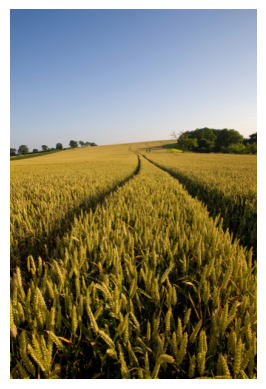

In [44]:
generate_caption("1263324992.jpg")

In [35]:
cider_score, _ = cider_scorer.compute_score(cider_data, cider_pred)
print("CIDEr score: %f" % cider_score)

0.7451
